In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Fetch the data
msft = yf.Ticker("MSFT").history(period="2y")['Close'].values
aapl = yf.Ticker("AAPL").history(period="2y")['Close'].values

# Reshape to (# of examples, # of features)
msft = msft.reshape(-1, 1)
aapl = aapl.reshape(-1, 1)

# Concatenate the stocks' data
data = np.concatenate((msft, aapl), axis=1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [7]:
X_train.shape[1]

60

Epoch 1/10
12/12 [==============================] - 4s 7ms/step - loss: 0.0827
Epoch 2/10
12/12 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 3/10
12/12 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 4/10
12/12 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 5/10
12/12 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 6/10
12/12 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 7/10
12/12 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 8/10
12/12 [==============================] - 0s 7ms/step - loss: 0.0115
Epoch 9/10
12/12 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 10/10
3/3 [==============================] - 0s 4ms/step


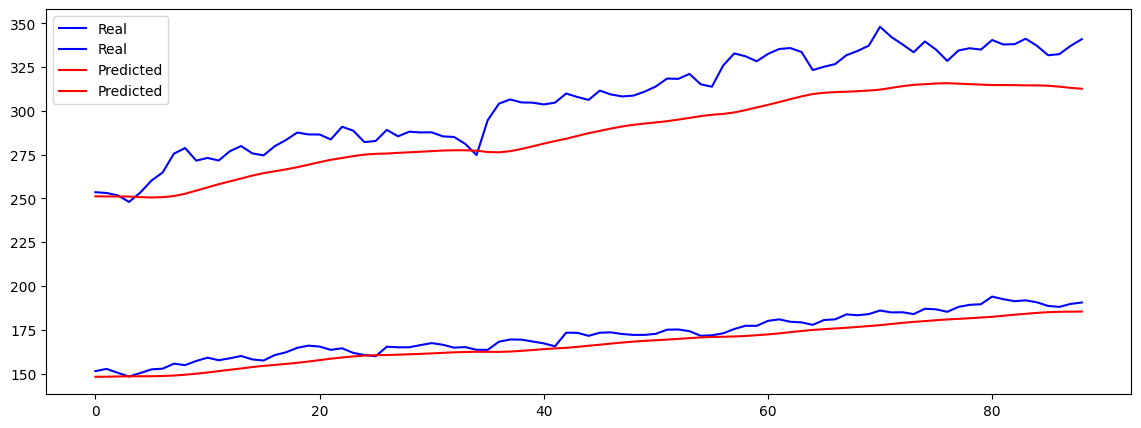

In [6]:
# Create sequences of 60 days and the target is the next day
X = []
y = []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i, :])

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2))  # two stocks -> two output neurons

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict
predictions = model.predict(X_test)

# Un-normalize the predicted data
predictions = scaler.inverse_transform(predictions)

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test), color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicted')
plt.legend()
plt.show()

---

In [16]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Flatten

# Stocks to download
stocks = ['AAPL', 'MSFT', 'BA', 'MMM', 'MCD', 'NKE', 'JNJ', 'XOM', 'GS', 'V']

# Define the dictionary
stock_dict = {}

# Download and store the stock data
for stock in stocks:
    # Download stock data
    data = yf.download(stock, start="2015-01-01", end="2022-06-30")

    # Only keep the 'Close' column
    data = data[['Close']]

    # Store in dictionary
    stock_dict[stock] = data

# Define the LSTM model
model = Sequential()

# Adding LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(units=50))

# Adding output layer
model.add(Dense(1))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Start with a large number
prev_mse = 10000000000

for stock in stocks:
    data = stock_dict[stock]
    data = data.values.reshape(-1, 1)

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Dividing into training and testing data
    training_data = scaled_data[:int(len(scaled_data)*0.8)]
    testing_data = scaled_data[int(len(scaled_data)*0.8)-100:]

    # Creating the training and testing datasets
    x_train, y_train = [], []
    for i in range(100, len(training_data)):
        x_train.append(training_data[i-100:i, 0])
        y_train.append(training_data[i, 0])

    # Reshape for LSTM input
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Fitting the model
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    # Creating the testing data
    x_test = []
    for i in range(100, len(testing_data)):
        x_test.append(testing_data[i-100:i, 0])

    # Reshape for LSTM input
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Predicting the stock prices
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Calculate MSE for this prediction
    mse = mean_squared_error(testing_data[100:], predictions)

    # If this MSE is less than the previous MSE, save this model
    if mse < prev_mse:
        model.save('best_model.h5')
        prev_mse = mse

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1408/1408 - 10s - loss: 8.3971e-04 - 10s/epoch - 7ms/step
12/12 [==============================] - 0s 3ms/step
1408/1408 - 8s - loss: 2.7072e-04 - 8s/epoch - 6ms/step
12/12 [==============================] - 0s 3ms/step
1408/1408 - 8s - loss: 0.0012 - 8s/epoch - 6ms/step
12/12 [==============================]

In [28]:
onehot_industries

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]])

In [30]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,0.029779,0.024949,0.024965,0.027301,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,...,0.066175,0.061596,0.065391,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.024949,0.024965,0.027301,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,0.024541,...,0.061596,0.065391,0.064984,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.024965,0.027301,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,0.024541,0.028822,...,0.065391,0.064984,0.062631,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.027301,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,0.024541,0.028822,0.030124,...,0.064984,0.062631,0.063039,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,0.024541,0.028822,0.030124,0.034593,...,0.062631,0.063039,0.062130,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16069,0.878895,0.869230,0.901923,0.918084,0.897592,0.880955,0.874459,0.878578,0.894053,0.866167,...,0.678251,0.701384,0.698373,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16070,0.869230,0.901923,0.918084,0.897592,0.880955,0.874459,0.878578,0.894053,0.866167,0.861413,...,0.701384,0.698373,0.713267,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16071,0.901923,0.918084,0.897592,0.880955,0.874459,0.878578,0.894053,0.866167,0.861413,0.864846,...,0.698373,0.713267,0.760114,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16072,0.918084,0.897592,0.880955,0.874459,0.878578,0.894053,0.866167,0.861413,0.864846,0.877945,...,0.713267,0.760114,0.749815,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, concatenate, Input
from keras.models import Model

# Stocks to download and their respective industries
stocks_industries = {'AAPL': 'Tech', 'MSFT': 'Tech', 'BA': 'Aerospace', 'MCD': 'Food', 
                     'NKE': 'Consumer', 'JNJ': 'Healthcare', 'XOM': 'Energy', 'GS': 'Finance', 'V': 'Finance'}

# Download and store the stock data
stock_data = {}
for stock in stocks_industries.keys():
    data = yf.download(stock, start="2015-01-01", end="2022-06-30")
    data = data[['Close']]
    stock_data[stock] = data

# One-hot encode industries
industries = np.array(list(stocks_industries.values())).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
onehot_industries = encoder.fit_transform(industries)

# Preprocess data and prepare for LSTM
x_train, y_train = [], []
for i, stock in enumerate(stocks_industries.keys()):
    data = stock_data[stock].values
    data_scaled = MinMaxScaler().fit_transform(data)
    for j in range(100, len(data)):
        x_train.append(np.concatenate((data_scaled[j-100:j, 0], onehot_industries[i])))
        y_train.append(data_scaled[j, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# LSTM model
inputs = Input(shape=(x_train.shape[1],))
x = Dense(50, activation='relu')(inputs)
x = Dense(50, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

# Training the model
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
16074/16074 [==============================] - 20s 1ms/step - loss: 0.0016


In [25]:
stock_datadd

{'AAPL':                  Close
 Date                  
 2015-01-02   27.332500
 2015-01-05   26.562500
 2015-01-06   26.565001
 2015-01-07   26.937500
 2015-01-08   27.972500
 ...                ...
 2022-06-23  138.270004
 2022-06-24  141.660004
 2022-06-27  141.660004
 2022-06-28  137.440002
 2022-06-29  139.229996
 
 [1886 rows x 1 columns],
 'MSFT':                  Close
 Date                  
 2015-01-02   46.759998
 2015-01-05   46.330002
 2015-01-06   45.650002
 2015-01-07   46.230000
 2015-01-08   47.590000
 ...                ...
 2022-06-23  258.859985
 2022-06-24  267.700012
 2022-06-27  264.890015
 2022-06-28  256.480011
 2022-06-29  260.260010
 
 [1886 rows x 1 columns],
 'BA':                  Close
 Date                  
 2015-01-02  129.949997
 2015-01-05  129.050003
 2015-01-06  127.529999
 2015-01-07  129.509995
 2015-01-08  131.800003
 ...                ...
 2022-06-23  133.970001
 2022-06-24  141.529999
 2022-06-27  138.720001
 2022-06-28  138.699997
 2022-06-2

In [23]:
stocks_industries

{'AAPL': 'Tech',
 'MSFT': 'Tech',
 'BA': 'Aerospace',
 'MCD': 'Food',
 'NKE': 'Consumer',
 'JNJ': 'Healthcare',
 'XOM': 'Energy',
 'GS': 'Finance',
 'V': 'Finance'}

In [22]:
data

array([[ 66.25499725],
       [ 64.79250336],
       [ 64.375     ],
       ...,
       [203.55999756],
       [198.11999512],
       [199.5       ]])

In [21]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,0.029779,0.024949,0.024965,0.027301,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,...,0.066175,0.061596,0.065391,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.024949,0.024965,0.027301,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,0.024541,...,0.061596,0.065391,0.064984,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.024965,0.027301,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,0.024541,0.028822,...,0.065391,0.064984,0.062631,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.027301,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,0.024541,0.028822,0.030124,...,0.064984,0.062631,0.063039,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.033793,0.033982,0.029653,0.031175,0.030516,0.025843,0.024541,0.028822,0.030124,0.034593,...,0.062631,0.063039,0.062130,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16069,0.878895,0.869230,0.901923,0.918084,0.897592,0.880955,0.874459,0.878578,0.894053,0.866167,...,0.678251,0.701384,0.698373,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16070,0.869230,0.901923,0.918084,0.897592,0.880955,0.874459,0.878578,0.894053,0.866167,0.861413,...,0.701384,0.698373,0.713267,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16071,0.901923,0.918084,0.897592,0.880955,0.874459,0.878578,0.894053,0.866167,0.861413,0.864846,...,0.698373,0.713267,0.760114,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16072,0.918084,0.897592,0.880955,0.874459,0.878578,0.894053,0.866167,0.861413,0.864846,0.877945,...,0.713267,0.760114,0.749815,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
mse

45547.95142280127